In [1]:
!pip install pydub

In [2]:
import numpy as np
from google.colab import drive
import os
import shutil
import IPython
from scipy.io import wavfile
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/word_trigger/data.zip" -d "dataset"
!unzip "/content/drive/MyDrive/word_trigger/example.zip" -d "example"


Archive:  /content/drive/MyDrive/word_trigger/data.zip
   creating: dataset/activates/
 extracting: dataset/activates/1.wav  
 extracting: dataset/activates/1_act2.wav  
 extracting: dataset/activates/1_act3.wav  
 extracting: dataset/activates/2.wav  
 extracting: dataset/activates/2_act2.wav  
 extracting: dataset/activates/2_act3.wav  
 extracting: dataset/activates/3.wav  
 extracting: dataset/activates/3_act2.wav  
 extracting: dataset/activates/3_act3.wav  
 extracting: dataset/activates/4_act2.wav  
   creating: dataset/backgrounds/
 extracting: dataset/backgrounds/1.wav  
 extracting: dataset/backgrounds/2.wav  
   creating: dataset/dev/
 extracting: dataset/dev/1.wav       
 extracting: dataset/dev/2.wav       
   creating: dataset/negatives/
 extracting: dataset/negatives/1.wav  
 extracting: dataset/negatives/1_0.wav  
 extracting: dataset/negatives/2.wav  
 extracting: dataset/negatives/2_1.wav  
 extracting: dataset/negatives/3.wav  
 extracting: dataset/negatives/3_2.wav 

In [5]:
IPython.display.Audio("./dataset/activates/1.wav")

In [6]:
IPython.display.Audio("./dataset/negatives/4.wav")

In [7]:
IPython.display.Audio("./dataset/backgrounds/1.wav")

In [8]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

#spectogram

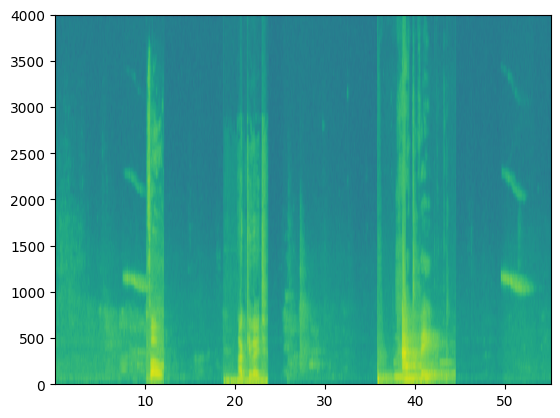

In [9]:
x = graph_spectrogram("example/example_train.wav")

In [10]:
x.shape

(101, 5511)

In [11]:
_, data = wavfile.read("example/example_train.wav")

In [12]:
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [13]:
Tx=5511
n_freq=101
Ty = 1375

In [14]:
def load_raw_Data(path):
  activates=[]
  negatives=[]
  backgrounds=[]
  for filename in os.listdir(path + "/activates"):
    if filename.endswith('wav'):
      activate=AudioSegment.from_wav(path+"/activates/"+filename)
      activates.append(activate)
  for filename in os.listdir(path + "/backgrounds"):
    if filename.endswith('wav'):
      background=AudioSegment.from_wav(path+"/backgrounds/"+filename)
      backgrounds.append(background)
  for filename in os.listdir(path + "/negatives"):
    if filename.endswith('wav'):
      negative=AudioSegment.from_wav(path+"/negatives/"+filename)
      negatives.append(negative)
  return activates,negatives,backgrounds

In [15]:
activates,negatives,backgrounds=load_raw_Data("/content/dataset")

In [16]:
#autosegment devide the audio to units each units represnet 1 ms 1ms =1/1000 secound
print("lenght of the background should be around 10000 units because it's 10 sec long ", len(backgrounds[0]))

lenght of the background should be around 10000 units because it's 10 sec long  10000


In [17]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

In [18]:
def get_random_time_segment(segment_s):
  start=np.random.randint(low=0,high=10000-segment_s)
  end=start + segment_s-1
  return start,end

In [19]:
def is_overalpping(segemnt_time,existing_segments):
  new_segment_start,new_segment_end=segemnt_time
  for segment in existing_segments:
    start,end =segment
    if new_segment_start>end or new_segment_end<start:
      continue
    else:
      return True
  return False


In [20]:
existing_segments=[]
def insert_audio(background,audio_clip,previous_segments):
    segment_ms = len(audio_clip)

    segment_time = get_random_time_segment(segment_ms)

    retry = 5 #
    while is_overalpping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1

    if not is_overalpping(segment_time, previous_segments):

        previous_segments.append(segment_time)

        new_background = background.overlay(audio_clip, position = segment_time[0])

    else:
        print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)

    return new_background, segment_time


In [21]:
background,_=insert_audio(backgrounds[0],activates[0],existing_segments)

In [22]:
background

In [23]:
def insert_ones(y,segment_end_ms):
  _,ty=y.shape
  segemnet_end_y=int(segment_end_ms*ty/10000)
  if segemnet_end_y<ty:
    for i in range(segemnet_end_y+1,segemnet_end_y+51):
      if i <ty:
        y[0,i]=1
  return y



sanity checks: 0.0 1.0 0.0


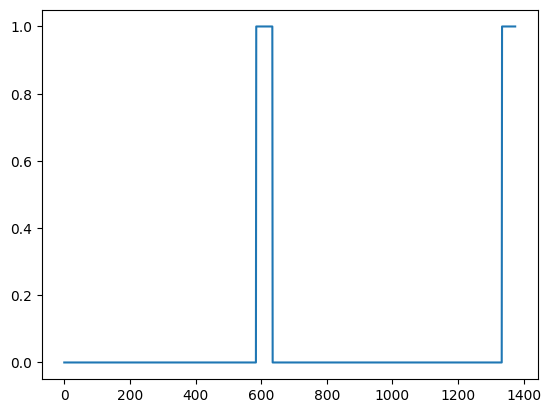

In [24]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [25]:
def creating_a_training_example(background,activates,negatives,Ty):
  background=background-20
  y=np.zeros((1,Ty))
  previous_segments =[]
  nb_activate=np.random.randint(0,5)
  indices=np.random.randint(len(activates),size=nb_activate)
  random_actives=[activates[i] for i in indices]
  for random_active in random_actives:
    background,segment=insert_audio(background,random_active,previous_segments)
    start,end=segment
    y=insert_ones(y,end)
  nb_negatives=np.random.randint(0,3)
  negative_indices=np.random.randint(len(negatives),size=nb_negatives)
  random_negatives=[negatives[i] for i in  negative_indices]
  for random_negative in random_negatives:
    background,_=insert_audio(background,random_negative,previous_segments)
  background=match_target_amplitude(background,-20)
  file_handle = background.export("train" + ".wav", format="wav")
  x=graph_spectrogram("/content/train.wav")
  return x,y,background








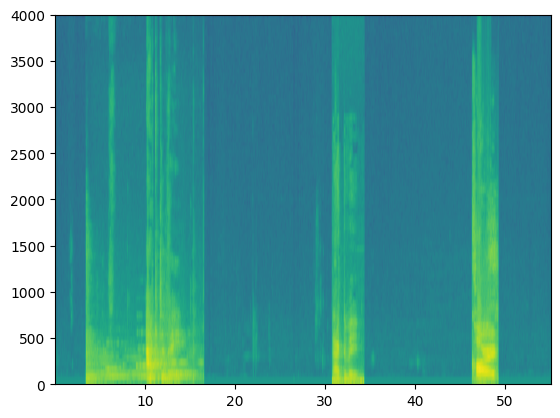

In [26]:
x,y,audio=creating_a_training_example(backgrounds[0],activates,negatives,Ty)

In [27]:
audio

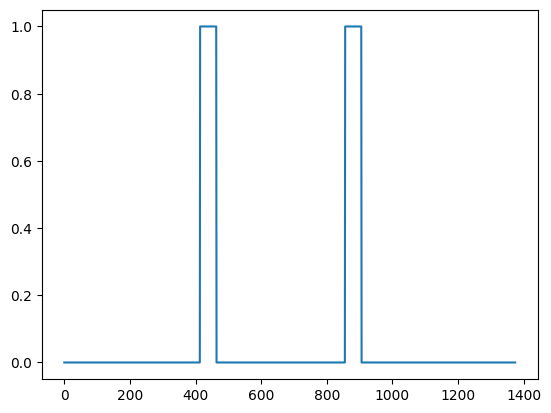

In [28]:
plt.plot(y[0,:])

In [29]:
y.shape

(1, 1375)

## create training examples


0
Timeouted
10
Timeouted
20
30


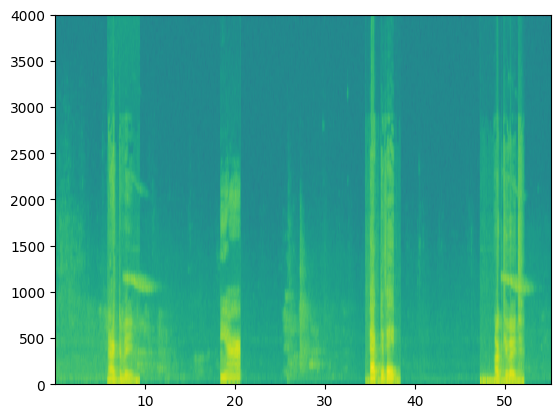

In [30]:
X=[]
Y=[]
num_sample=32
for i in range(0,num_sample):
  if i%10 == 0:
    print(i)
  x,y,_=creating_a_training_example(backgrounds[i%2],activates,negatives,Ty)
  X.append(x.swapaxes(0,1))
  Y.append(y.swapaxes(0,1))
X=np.array(X)
Y=np.array(Y)

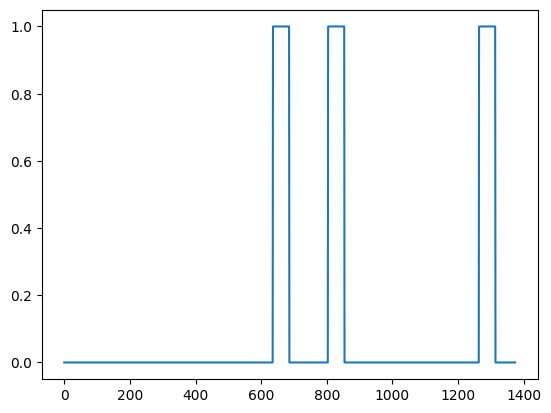

In [31]:
plt.plot(Y[0])

In [32]:
# x_dev=np.load("/content/drive/MyDrive/word_trigger/word_triger_devset/X_dev.npy")
y_dev=np.load("/content/drive/MyDrive/word_trigger/word_triger_devset/Y_dev.npy")

0
Timeouted
10
Timeouted
20
Timeouted


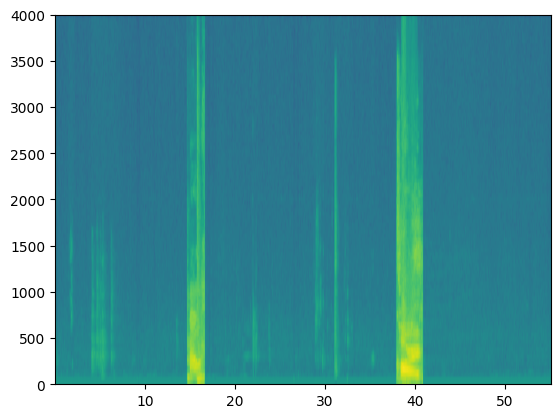

In [33]:
X_dev=[]
Y_dev=[]
num_sample=25
for i in range(0,num_sample):
  if i%10 == 0:
    print(i)
  x,y,_=creating_a_training_example(backgrounds[i%2],activates,negatives,Ty)
  X_dev.append(x.swapaxes(0,1))
  Y_dev.append(y.swapaxes(0,1))
X_dev=np.array(X_dev)
Y_dev=np.array(Y_dev)

## model

In [34]:
def modelf(input_shape):
  x_input=Input(shape=input_shape)
  x=Conv1D(196,15,strides=4)(x_input)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)
  x=Dropout(0.8)(x)
  x=GRU(units=128,return_sequences=True)(x)
  x=Dropout(0.8)(x)
  x=BatchNormalization()(x)
  x=GRU(units=128,return_sequences=True)(x)
  x=Dropout(0.8)(x)
  x=BatchNormalization()(x)
  x=TimeDistributed(Dense(1,activation ="sigmoid"))(x)
  model= Model(inputs=x_input,outputs=x)
  return model



In [35]:
model=modelf((Tx,n_freq))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5511, 101)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1375, 196)           │         297,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1375, 196)           │             784 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1375, 196)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1375, 196)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 1375, 128)           │         125,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1375, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1375, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 1375, 128)           │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1375, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1375, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1375, 1)             │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 523,329 (2.00 MB)

 Trainable params: 522,425 (1.99 MB)

 Non-trainable params: 904 (3.53 KB)

In [36]:
# opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [37]:
# model.fit(X, Y, batch_size = 16, epochs=1)

In [2]:
# from keras.saving import register_keras_serializable

# # Make sure to register 'Functional'
# @register_keras_serializable()
# class Functional:
#     pass


In [1]:
# from tensorflow.keras.models import model_from_json
# import tensorflow as tf
# with open("/content/drive/MyDrive/word_trigger/model.json","r") as f :
#   load_json_file=f.read()
# model=model_from_json(load_json_file)
# model.load_weights("/content/drive/MyDrive/word_trigger/model.h5")

# with open('/content/drive/MyDrive/word_trigger/model.json', 'r') as json_file:
#     loaded_model_json = json_file.read()

# model = model_from_json(loaded_model_json, custom_objects={"Functional": tf.keras.Model})
# model.load_weights('/content/drive/MyDrive/word_trigger/model.h5')
